In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import string
import h5py
import torch.nn.functional as F
import string
import re
import sys
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from dataclasses import dataclass

from datetime import datetime

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel,GPT2Config

gptconfig = GPT2Config.from_pretrained("gpt2",add_cross_attention=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token
#tokenizer.add_special_tokens({"bos_token":"<s>","eos_token":"</s>"})
gpt2 = GPT2LMHeadModel.from_pretrained("gpt2",config=gptconfig)
gpt2.to(device)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (crossattention): GPT2Attention(
          (c_attn): Conv1D(nf=1536, nx=768)
          (q_attn): Conv1D(nf=768, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_cross_attn): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): C

In [4]:
df=pd.read_csv("how2sign.csv",sep="\t")
df.tail()
asl_df=pd.read_csv("ASLens-landmarks.csv")
print(asl_df.iloc[121])
asl_df.drop(121,inplace=True)
asl_df.index = np.arange(0,len(asl_df))
#asl_df.drop("Unnamed: 0", axis=1, inplace=True)
asl_df.head()

file_name       g0yUlOaqL6k
landmarks    g0yUlOaqL6k.h5
frames                 2026
sentences                24
Name: 121, dtype: object


,file_name,landmarks,frames,sentences
0,FzmL8SL6Bow,FzmL8SL6Bow.h5,1196,4
1,FZrU_mEryAs,FZrU_mEryAs.h5,1213,7
2,-g45vqccdzI,-g45vqccdzI.h5,1332,10
3,FzUdcaxw_vs,FzUdcaxw_vs.h5,1826,19
4,-g0iPSnQt6w,-g0iPSnQt6w.h5,1657,17


In [5]:
class ASLensDataset(Dataset):
  def __init__(self, df, asl_df, tokenizer=None, seq_len=128):
    self.tokenizer=tokenizer
    self.df=df
    self.asl_df=asl_df
    self.seq_len=seq_len
  def __len__(self):
    return self.asl_df['sentences'].sum()

  def extract_number(self,sentence_id):
    # Extract the numeric part after the last underscore
    match = re.search(r'_(\d+)$', sentence_id)
    return int(match.group(1)) if match else 0

  def extractFrames(self,ex,index):
    fName=self.asl_df["landmarks"][index]
    file=h5py.File(f"landmarks/{fName}")
    start_frame=int(ex["START_REALIGNED"]*15)
    end_frame=int(ex["END_REALIGNED"]*15)
    hand_left=file["handLeft"][start_frame:end_frame]
    # print(self.asl_df["frames"][index])
    # print(start_frame,end_frame)
    hand_right=file["handRight"][start_frame:end_frame]
    face_lips=file["faceLips"][start_frame:end_frame]
    face_oval=file["faceOval"][start_frame:end_frame]
    file.close()
    #x = self.text[idx:idx + self.seq_len]
    x=np.concatenate([hand_left,hand_right,face_lips,face_oval],axis=1)
    return torch.tensor(x)
  def __getitem__ (self, idx):
    index=0
    while idx>self.asl_df['sentences'][index]-1:
      idx-=self.asl_df['sentences'][index]
      index+=1
    file_name=self.asl_df["file_name"][index]

    if file_name[-1]=="-":

      file_name=file_name[:-1]
    sent=df[df['VIDEO_ID']==file_name]
    sent = sent.copy()  # Explicit copy
    sent['SENTENCE_NUM'] = sent['SENTENCE_ID'].apply(self.extract_number)
    sent = sent.sort_values(["VIDEO_NAME","SENTENCE_NUM"])

    if len(sent[sent.duplicated("SENTENCE_ID")])>0:
      first = sent.drop_duplicates(subset="SENTENCE_NUM",keep="first")
      last = sent.drop_duplicates(subset="SENTENCE_NUM",keep="last")
      numOfFrames=self.asl_df["frames"][index]
      if numOfFrames>first["END_REALIGNED"].max()*15:
        sent = first
      else:
        sent = last
    #print(sent)
    ex=sent.iloc[idx]

    frames=self.extractFrames(ex,index)
    frames=frames.type(torch.float32)
    text=ex["SENTENCE"]+tokenizer.eos_token
    
    if self.tokenizer:
        inputs = self.tokenizer(text[:int(len(text)*0.33)], return_tensors="pt", padding="max_length", max_length=20, truncation=True,add_special_tokens=True)
        labels = self.tokenizer(text[int(len(text)*0.33):], return_tensors="pt", padding="max_length", max_length=20, truncation=True).input_ids
    return frames, text[:int(len(text)*0.33)], text[int(len(text)*0.33):]



In [6]:
test_size = 0.15
test_df = asl_df.iloc[int(len(asl_df)*(1-test_size)):]
test_df.index = np.arange(0,len(test_df))

In [7]:
test_asl_dataset = ASLensDataset(df,test_df,tokenizer=None)
test_loader = DataLoader(test_asl_dataset, batch_size=1, shuffle=False)

In [8]:
@dataclass
class ModelConfig:
    hidden_size: int
    num_layers: int
    dropout_rate:  float =0.1
    learning_rate:float= 0.001 

In [9]:

class ASLensEncoder(nn.Module):
  def __init__(self,config):
    super(ASLensEncoder,self).__init__()
    self.config=config
    self.conv1 = nn.Sequential(
        #nn.Conv2d(1,16,kernel_size=(3,1),padding=(1,0)),
        #nn.ReLU(),

       # nn.MaxPool2d(kernel_size=(2,2)),
        #nn.Conv2d(16,32,kernel_size=(2,1),padding=(1,0)),
       # nn.ReLU(),
        #nn.Conv2d(64,128,kernel_size=(3,3)),
        #nn.ReLU(),
        #nn.Flatten()
      nn.Conv1d(3, 16, kernel_size=3, padding=1),  # preserves (90, 3)
      nn.ReLU(),
      nn.Conv1d(16, 32, kernel_size=2,padding=1),                 # reduces width
      nn.ReLU(),
      nn.Conv1d(32, 64, kernel_size=2,padding=1),                 # reduces width
      nn.ReLU(),
      #nn.AdaptiveAvgPool2d((45, 3))
        #nn.Conv3d(128,64,kernel_size=(3,3,1)),
        #nn.ReLU(),
        )
    self.lstm= nn.LSTM(input_size=98,
                       hidden_size=self.config.hidden_size,
                       num_layers=config.num_layers,
                       dropout=config.dropout_rate,
                       batch_first=True)


  def forward(self,x):
    #x = x.permute(0, 3, 1, 2)  # [32, 3, 100, 90]
    #x = x.unsqueeze(-1)
    time = x.shape[2]
    x=x.view(-1, 98,3)
    x=x.permute(1,2, 0)
    out = self.conv1(x)
    #out,_ = torch.max(out,2)
    #out = out.view(out.shape[0],-1)
   # return out
    out=out.reshape(1, -1, 98).contiguous()
    out,hidden = self.lstm(out)
    return out,hidden

In [10]:
config = ModelConfig(hidden_size=128,num_layers=2,dropout_rate=0.2)
encoder = ASLensEncoder(config)
encoder.to(device)

ASLensEncoder(
  (conv1): Sequential(
    (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    (5): ReLU()
  )
  (lstm): LSTM(98, 128, num_layers=2, batch_first=True, dropout=0.2)
)

In [11]:
class GPT2ConditionedOnEncoder(nn.Module):
    def __init__(self, encoder, hidden_size=768):
        super().__init__()
        self.encoder = encoder
        self.gpt2 = GPT2LMHeadModel.from_pretrained("gpt2",config=gptconfig)
        self.gpt2.resize_token_embeddings(self.gpt2.config.vocab_size + 2)  # in case of custom tokenizer
        self.projection = nn.Linear(hidden_size, self.gpt2.config.n_embd)

    def forward(self, landmarks, input_ids, attention_mask,labels=None,proj=False):
        # frames: [1, seq_len, 98, 3] or similar
        #if proj == False:
        encoder_output, (h_n, _) = self.encoder(landmarks)  # h_n: [num_layers, 1, hidden_size]
        h_n = h_n[-1]  # use top layer [1, hidden_size]
        projected = self.projection(h_n)  # [1, emb_dim]
        projected = projected.unsqueeze(1)  # [1, 1, emb_dim]
       # else:
         # projected=landmarks
        # Get input embeddings
        #input_embeds = self.gpt2.transformer.wte(input_ids)  # [1, seq_len, emb_dim]
        #input_embeds = torch.cat([projected, input_embeds], dim=1)  # [1, seq_len+1, emb_dim]
       # attention_mask = torch.cat([
       #     torch.ones((input_ids.size(0), 1), dtype=torch.long, device=input_ids.device),
        #    attention_mask
       # ], dim=1)
        # Assume labels: [batch, seq_len]
        #if labels is not None:
        #  ignore_label = torch.full((labels.size(0),1), -100, dtype=labels.dtype, device=labels.device)
        #  labels = torch.cat([ignore_label, labels], dim=1)
        #print(torch.isnan(encoder_output).any())
        outputs = self.gpt2(input_ids=input_ids, encoder_hidden_state=encoder_output, labels=labels)
        return outputs.logits,outputs.loss,projected

In [12]:
model = GPT2ConditionedOnEncoder(encoder,hidden_size=config.hidden_size)
model.to(device)
print()
model.load_state_dict(torch.load('asl_lens_model_gpt2_checkpoint_hidden1.pt',map_location=device,weights_only=False)['model_state_dict'])

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

<All keys matched successfully>

In [13]:
!pip install jiwer

In [14]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from mosestokenizer import MosesTokenizer
from mosestokenizer import MosesDetokenizer
import subprocess
import tempfile
import os
from rouge_score import rouge_scorer
from jiwer import wer  # Install with: pip install jiwer

# Download NLTK data (run once)
nltk.download('wordnet')
nltk.download('omw-1.4')

def compute_metrics(reference, hypothesis):
    # Tokenize sentences
    tokenize = MosesTokenizer('en')
    detokenize = MosesDetokenizer('en')
    
    ref_tokens = tokenize(reference)
    hyp_tokens = tokenize(hypothesis)
    
    # Compute BLEU (with smoothing)
    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(
        [ref_tokens],
        hyp_tokens,
        smoothing_function=smoothing
    )
    
    # Compute METEOR
    meteor_score_val = meteor_score(
        [ref_tokens],
        hyp_tokens
    )
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    
    return {
        "BLEU": bleu_score,
        "METEOR": meteor_score_val,
        "ROUGE-1": rouge_scores['rouge1'].fmeasure,
        "ROUGE-2": rouge_scores['rouge2'].fmeasure,
        "ROUGE-L": rouge_scores['rougeL'].fmeasure,
        "WER": wer(reference, hypothesis)
    }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to eos token

In [16]:
metrics=[]
for i in range(len(test_asl_dataset)):
    data, x, y = test_asl_dataset.__getitem__(i)
    data = data.to(device)  # Move data to device first
    
    decoded_text = x
    for i in range(len(y)):
        inputs = tokenizer(decoded_text, return_tensors="pt").to(device)
        input_ids = inputs.input_ids.to(device)
        mask = inputs.attention_mask.to(device)
        
        # All operations now on device
        encoder_output, (h_n, _) = model.encoder(data)  # data is already on device
        h_n = h_n[-1]
        projected = model.projection(h_n)  # No need to move to device again
        projected = projected.unsqueeze(1)
        
        # Ensure all inputs are on same device
        t = gpt2.generate(
            input_ids=input_ids,
            attention_mask=mask,
            pad_token_id=tokenizer.pad_token_id,
            encoder_hidden_states=projected,
            max_length=input_ids.shape[1]+1
        )
        
        decoded_text = tokenizer.decode(t[0], skip_special_tokens=True)
    
    metrics.append(compute_metrics(y, decoded_text.replace("\n", "")))

In [19]:
b={'BLEU': 0.,
  'METEOR': 0.,
  'ROUGE-1': 0.,
  'ROUGE-2': 0.0,
  'ROUGE-L': 0.,
  'WER': 0.}
for k in metrics:
    b["BLEU"]+=k["BLEU"]
    b["METEOR"]+=k["METEOR"]
    b["ROUGE-1"]+=k["ROUGE-1"]
    b["ROUGE-2"]+=k["ROUGE-2"]
    b["ROUGE-L"]+=k["ROUGE-L"]
    b["WER"]+=k["WER"]


In [20]:
b["BLEU"]/=len(test_asl_dataset)
b["METEOR"]/=len(test_asl_dataset)
b["ROUGE-1"]/=len(test_asl_dataset)
b["ROUGE-2"]/=len(test_asl_dataset)
b["ROUGE-L"]/=len(test_asl_dataset)
b["WER"]/=len(test_asl_dataset)

<Axes: >

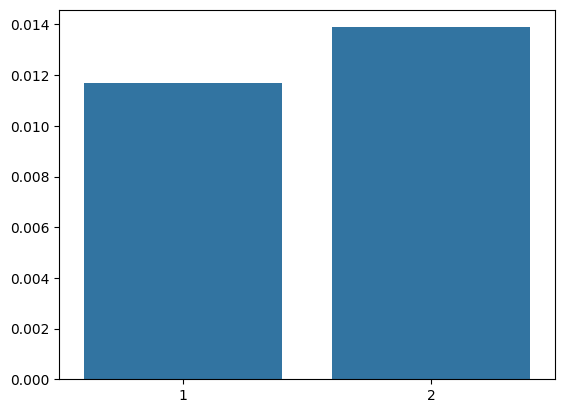

In [25]:
import seaborn as sns
sns.barplot(x=[1,2],y=[0.01168,0.01389])